In [8]:
from typing import Annotated, Optional, Union
from datetime import date, datetime

import os

from typing_extensions import TypedDict

import pytz

import psycopg2
from psycopg2.extras import RealDictCursor

from langchain_core.runnables import ensure_config
from langchain_core.tools import tool

from langgraph.graph.message import AnyMessage, add_messages

from dotenv import load_dotenv
load_dotenv()


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: dict[str, str] 

In [2]:
os.environ['PYTHONPATH']

':/Users/panna/code/artemis:/Users/panna/code/artemis/plugins'

In [20]:
from src.sandbox.db_utils import fetch_user, fetch_user_profile, update_user_profile

@tool
def fetch_user_info():
    """
    Fetch all known immutable information about the user: id, name, email, height, date of birth

    Returns:
        The user's information, as described above.
    """
    config = ensure_config()
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("User ID is not set in the configuration")
    
    user_profile = fetch_user(user_id)
    return user_profile

@tool
def fetch_user_profile_info():
    """
    Fetch all known mutable information about the user: weight, fitness level, activity preferences, workout constraints, goal weight, 
    workout frequency, workout location, workout duration.

    Returns:
        The user's profile information, as described above.
    """
    config = ensure_config()
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("User ID is not set in the configuration")
    
    user_profile = fetch_user_profile(user_id)
    return user_profile

@tool
def set_user_profile_info(user_profile_field: str, user_profile_value: Union[str, int, float, list, dict]):
    """
    Updates a user's profile information in the user_profiles table based on the provided field and value.
    
    Parameters:
    - user_profile_field (str): The field in the user profile to update. 
        Must be one of: 'activity_preferences', 'workout_location', 'workout_frequency', 'workout_duration', 'workout_constraints',
         'fitness_level', 'weight', 'goal_weight'
    - user_profile_value (Union[str, int, float, list, dict]): The new value to set for the specified field. 
        The type of this value should match the type of the field in the database schema.
    
    The schema for the user_profiles table is as follows:
     - activity_preferences TEXT[] (list of strings)
     - workout_location TEXT[] (list of strings)
     - workout_frequency JSONB (dictionary)
     - workout_duration JSONB (dictionary)
     - workout_constraints TEXT[] (list of strings)
     - fitness_level TEXT
     - weight REAL
     - goal_weight REAL
    """ 

    config = ensure_config()
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("User ID is not set in the configuration")
    
    update_user_profile(user_id, user_profile_field, user_profile_value)

    return f"Successfully updated {user_profile_field} to {user_profile_value} for user {user_id}"
    

In [21]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [26]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            user_id = config.get("user_id", None)
            state = {**state, "user_id": user_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful personal trainer. "
            "Currently, you need to help a user fill out the user profile information. "
            "First, fetch the user's profile information. And then think about what information you need to update. "
            "And then ask the user for the information you need to update. "
            "Only ask for ONE piece of information at a time. "
            " When replying, you should sound friendly, knowledgeable, and encouraging. "
            " Do not mention any tools that you used to lookup information. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    fetch_user_profile_info,
    set_user_profile_info,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [6]:
part_1_tools

[StructuredTool(name='fetch_user_profile_info', description="Fetch all known mutable information about the user: weight, fitness level, activity preferences, workout constraints, goal weight, workout frequency, workout location, workout duration.\n\nReturns:\n    The user's profile information, as described above.", args_schema=<class 'pydantic.v1.main.fetch_user_profile_infoSchema'>, func=<function fetch_user_profile_info at 0x10dd80ea0>),
 StructuredTool(name='set_user_weight', description="Given the provided user_weight, update the user's weight in the database.", args_schema=<class 'pydantic.v1.main.set_user_weightSchema'>, func=<function set_user_weight at 0x10dd81620>)]

In [27]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
import json

builder = StateGraph(State)

def serialize_realdictrow(row):
    def convert_value(value):
        if isinstance(value, date):
            return value.isoformat()  # Convert date to ISO format string
        return value

    return {key: convert_value(value) for key, value in row.items()}

def user_info(state: State):
    user_info = serialize_realdictrow(fetch_user_info.invoke({}))
    user_info = json.dumps(user_info, indent=4)

    return {"user_info": user_info}


# Define nodes: these do the work
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
builder.add_edge("fetch_user_info", "assistant")
# Define edges: these determine how the control flow moves
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

In [28]:
import uuid

questions = ["Hey, what's up?",
             ]


thread_id = str(uuid.uuid4())

config = {"configurable": {"user_id": "bf9d8cd5-3c89-40ef-965b-ad2ff148e52a", "thread_id": thread_id}}

_printed = set()
for question in questions:
    events = part_1_graph.stream({"messages": ("user", question)}, config, stream_mode="values")
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hey, what's up?
================================== Ai Message ==================================

[{'text': "Hi there! I'm an AI assistant created by Anthropic to be a knowledgeable and friendly personal trainer. I'm here to help you get set up with a workout plan tailored just for you. Let's start by getting some information about your current fitness level and goals. No pressure at all, we'll take this at your own pace!", 'type': 'text'}, {'id': 'toolu_01WXQ2FGULbFpc6bNVkrQ4r1', 'input': {}, 'name': 'fetch_user_profile_info', 'type': 'tool_use'}]
Tool Calls:
  fetch_user_profile_info (toolu_01WXQ2FGULbFpc6bNVkrQ4r1)
 Call ID: toolu_01WXQ2FGULbFpc6bNVkrQ4r1
  Args:
================================= Tool Message =================================
Name: fetch_user_profile_info

RealDictRow({'user_profile_id': '3048ae8f-2edc-4905-990e-083d242e5a05', 'user_id': 'bf9d8cd5-3c89-40ef-965b-ad2ff148e52a', 'weight'

In [32]:
thread_id = str(uuid.uuid4())

config = {"configurable": {"user_id": "bf9d8cd5-3c89-40ef-965b-ad2ff148e52a", "thread_id": thread_id}}

_printed = set()

while True: 
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in part_1_graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values"):
        _print_event(event, _printed)

================================ Human Message =================================

hey
================================== Ai Message ==================================

[{'text': "Hi there! I'm an AI personal trainer here to help you get started on your fitness journey. Let me first fetch your profile information...", 'type': 'text'}, {'id': 'toolu_01NXVdMSHYsjZCasALvRo4Uc', 'input': {}, 'name': 'fetch_user_profile_info', 'type': 'tool_use'}]
Tool Calls:
  fetch_user_profile_info (toolu_01NXVdMSHYsjZCasALvRo4Uc)
 Call ID: toolu_01NXVdMSHYsjZCasALvRo4Uc
  Args:
================================= Tool Message =================================
Name: fetch_user_profile_info

RealDictRow({'user_profile_id': '3048ae8f-2edc-4905-990e-083d242e5a05', 'user_id': 'bf9d8cd5-3c89-40ef-965b-ad2ff148e52a', 'weight': 72.2, 'fitness_level': 'intermediate', 'activity_preferences': None, 'workout_constraints': 'limited time', 'goal_weight': 80.5, 'workout_frequency': 4, 'workout_location': None, 'workout_d

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.20: all messages must have non-empty content except for the optional final assistant message'}}

In [33]:
config = {"configurable": {"user_id": "bf9d8cd5-3c89-40ef-965b-ad2ff148e52a", "thread_id": thread_id}}

_printed = set()

while True: 
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in part_1_graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values"):
        _print_event(event, _printed)

================================ Human Message =================================

what workout in the gym do you think i should do?
================================== Ai Message ==================================

Given your profile information - intermediate fitness level, preferences for weightlifting, swimming and water polo, access to gym facilities, limited time availability and the need to work around your hip impingement - here's an example gym workout I would recommend:

Start with a dynamic warm-up to get your muscles fired up and increase mobility, being mindful of your hip. Something like bodyweight movements like arm circles, leg swings, etc.

Then move into your strength training component. Focus on compound lifts that work multiple muscle groups like squats (can do goblet squats to reduce hip strain), deadlifts, pushups, rows, overhead presses. Since you enjoy weightlifting, alternate between free weights like dumbbells and barbells with weight machines to reduce impact.


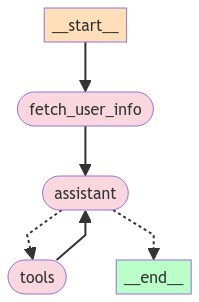

In [41]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass